# Machine Learning Lab: A Simple Neural Network on MNIST with JAX

In this lab, we will
1. Downloads and loads MNIST into NumPy arrays (if it doesn't already exist locally).
2. Builds a simple Multi-Layer Perceptron in JAX.
3. Trains the network on MNIST.
4. Evaluates the performance on test data.
5. Provides a custom inference function for your own handwriting images.

This lab is based on a [JAX example](https://github.com/jax-ml/jax/blob/main/examples/mnist_classifier_fromscratch.py).
Please notice that MNIST is the "hello world" for machine learning, and there are **many many** examples available online, including some simplier ones that use libraries:
[JAX with pre-built optimizers](https://github.com/jax-ml/jax/blob/main/examples/mnist_classifier.py), [FLAX](https://flax.readthedocs.io/en/latest/mnist_tutorial.html), and [pytorch](https://github.com/pytorch/examples/tree/main/mnist), [Keras](https://www.tensorflow.org/datasets/keras_example).

## MNIST Data Loader

We start by downloading the MNIST data set and store it locally.
Our data loader will parse, reshape, normalize them, and return them in NumPy arrays.

In [1]:
from os.path import isfile
from urllib.request import urlretrieve

base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

# File names
files = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images":  "t10k-images-idx3-ubyte.gz",
    "test_labels":  "t10k-labels-idx1-ubyte.gz",
}

for key, file in files.items():
    if not isfile(file):
        url = base_url + file
        print(f"Downloading {url} to {file}...")
        urlretrieve(url, file)
    else:
        print(f"{file} exists; skip download")

train-images-idx3-ubyte.gz exists; skip download
train-labels-idx1-ubyte.gz exists; skip download
t10k-images-idx3-ubyte.gz exists; skip download
t10k-labels-idx1-ubyte.gz exists; skip download


In [2]:
import gzip
import struct
import array
from jax import numpy as np

# Parsing functions
def parse_labels(file):
    with gzip.open(file, "rb") as fh:
        _magic, num_data = struct.unpack(">II", fh.read(8))
        # Read the label data as 1-byte unsigned integers
        return np.array(array.array("B", fh.read()), dtype=np.uint8)

def parse_images(file):
    with gzip.open(file, "rb") as fh:
        _magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
        # Read the image data as 1-byte unsigned integers
        images = np.array(array.array("B", fh.read()), dtype=np.uint8)
        # Reshape to (num_data, 28, 28)
        images = images.reshape(num_data, rows, cols)
        return images

In [3]:
# Parse raw data

train_images_raw = parse_images(files["train_images"])
train_labels_raw = parse_labels(files["train_labels"])

test_images_raw  = parse_images(files["test_images"])
test_labels_raw  = parse_labels(files["test_labels"])

In [4]:
# Standardize the images, i.e., flatten and normalize images to [0, 1]
def standardize(images):
    return images.reshape(-1, 28*28).astype(np.float32) / 255

train_images = standardize(train_images_raw)
test_images  = standardize(test_images_raw)

In [5]:
# One-hot encode labels
def one_hot(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels = one_hot(train_labels_raw, 10).astype(np.float32)
test_labels  = one_hot(test_labels_raw,  10).astype(np.float32)

## Visualize Some Training and Testing Data

In [6]:
from matplotlib import pyplot as plt

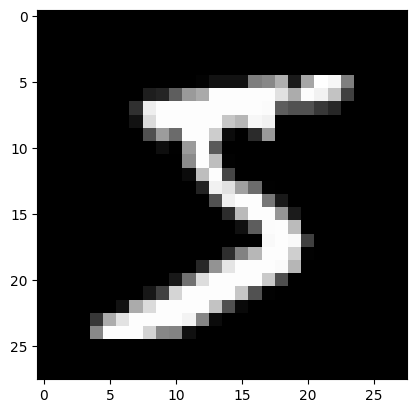

In [7]:
plt.imshow(train_images_raw[0,:,:], cmap='gray')

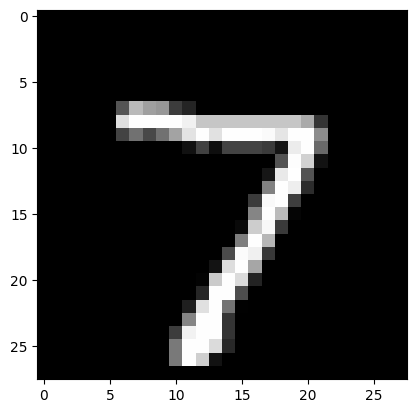

In [8]:
plt.imshow(test_images_raw[0,:,:], cmap='gray')

## Define a Simple Neural Network in JAX

In this subsection, we introduce the core function needed to **initialize** the parameters of a multi-layer network.
Our network will have multiple layers, each characterized by a weight matrix `W` and a bias vector `b`.
We will use random initialization scaled by a small factor to ensure stable starting values for training.

In [9]:
import numpy.random as npr

def init_params(scale, layer_sizes, rng=npr.RandomState(0)):
    """
    Initialize the parameters (weights and biases) for each layer in the network.

    Parameters
    ----------
    scale : float
        A scaling factor to control the initial range of the weights.
    layer_sizes : list of int
        The sizes of each layer in the network.
        e.g., [784, 1024, 1024, 10] means:
            - Input layer: 784 units
            - Hidden layer 1: 1024 units
            - Hidden layer 2: 1024 units
            - Output layer: 10 units
    rng : numpy.random.RandomState
        Random state for reproducibility.

    Returns
    -------
    params : list of tuples (W, b)
        Each tuple contains (W, b) for a layer.
        - W is a (input_dim, output_dim) array of weights
        - b is a (output_dim,) array of biases
    """
    return [
        (scale * rng.randn(m, n), scale * rng.randn(n))
        for m, n in zip(layer_sizes[:-1], layer_sizes[1:])
    ]

How it works:
* We specify a list of layer sizes: for example, `[784, 1024, 1024, 10]`.
* For each pair of consecutive sizes `(m, n)`, we create a weight matrix W of shape `(m, n)` and a bias vector `b` of shape `(n,)`.
* Multiplying by scale ensures that initial values are not too large, which helps prevent numerical issues early in training.
* We store all `(W, b)` pairs in a list, one pair per layer, to be used throughout training and inference.

By calling `init_params(scale, layer_sizes)`, you obtain an easy-to-manipulate structure that keeps all the parameters needed for your neural network.

In [10]:
# Define network architecture and hyperparameters

layer_sizes = [784, 1024, 1024, 10]  # 2 hidden layers
param_scale = 0.1

In [11]:
# Initialize parameters

params = init_params(param_scale, layer_sizes)

## Forward Pass: The `predict` Function

Once the network parameters are initialized, we need a function to perform the **forward pass**, producing an output for each batch of inputs.
Below, we define `predict` to process data through multiple layers—using a `tanh` activation on the hidden layers—and compute a **log-softmax** on the final output layer for stability.

In [12]:
from jax import numpy as np
from jax.scipy.special import logsumexp

In [13]:
def predict(params, inputs):
    """
    Compute the network's output logits for a batch of inputs, then subtract
    log-sum-exp for numerical stability (log-softmax).

    Network architecture:
      - Hidden layers use tanh activation
      - Output layer is linear (we'll do log-softmax here)

    Parameters
    ----------
    params : list of (W, b) tuples
        Network's parameters for each layer.
    inputs : np.ndarray
        A batch of input data of shape (batch_size, input_dim).

    Returns
    -------
    np.ndarray
        Log probabilities of shape (batch_size, 10).
    """
    activations = inputs
    # Hidden layers
    for w, b in params[:-1]:
        



        
        outputs = np.dot(activations, w) + b
        activations = np.tanh(outputs)

 
    # Final layer (logits)
    final_w, final_b = params[-1]
    logits = np.dot(activations, final_w) + final_b

    # Log-Softmax: subtract logsumexp for numerical stability
    return logits - logsumexp(logits, axis=1, keepdims=True)

* Hidden Layers (`tanh`): Each hidden layer applies a linear transformation (`np.dot(activations, w) + b`) followed by the hyperbolic tangent activation function (`np.tanh`).
* Final Layer (`logits`): The last layer's output is not activated by tanh; instead, we use it directly as logits.
* Log-Softmax: We transform logits to log probabilities by subtracting the logsumexp(logits) along the class dimension.
  This step ensures numerical stability and can be directly used to compute losses like cross-entropy.

## Defining the Loss Function

To guide training, we need a **loss function** that measures how well our network's predictions match the true labels.
This is like $\chi^2$ when we need to fit a curve.
Below, we define a function that computes the **negative log-likelihood** (NLL) over a batch of data.

In [14]:
def loss(params, batch):
    """
    Computes the average negative log-likelihood loss for a batch.

    Parameters
    ----------
    params : list of (W, b) tuples
        The network's parameters.
    batch : tuple (inputs, targets)
        - inputs: np.ndarray of shape (batch_size, 784)
        - targets: np.ndarray of shape (batch_size, 10) (one-hot labels)

    Returns
    -------
    float
        Mean negative log-likelihood over the batch.
    """


    
    inputs, targets = batch
    preds = predict(params, inputs)

    print(np.shape(preds*targets))

    # preds are log-probs, multiply with one-hot targets and sum -> log-likelihood
    return -np.mean(np.sum(preds * targets, axis=1))

* Inputs and Targets: A single batch typically consists of a set of input vectors (inputs) and corresponding one-hot encoded labels (targets).
* Forward Pass: We call predict(params, inputs), which returns the log probabilities for each class.
* NLL Computation: We multiply the log probabilities by the one-hot labels (so we only pick out the log probability of the correct class for each example). Summing these values (log-likelihood) and then negating yields the negative log-likelihood.
* Mean Value: We take the average across the batch, yielding a scalar loss.

This loss metric drives parameter updates: minimizing it pushes the network to assign higher probabilities to the correct classes.

## Evaluating Model Performance

While the network is trained by minimizing the negative log-likelihood (NLL), we often monitor **accuracy** to get an intuitive sense of model performance.
The function below calculates the fraction of samples in a batch that are correctly classified.

In [15]:
def accuracy(params, batch):
    """
    Computes classification accuracy of the network on a given batch.

    Parameters
    ----------
    params : list of (W, b) tuples
        The network's parameters.
    batch : tuple (inputs, targets)
        - inputs: np.ndarray (batch_size, 784)
        - targets: np.ndarray (batch_size, 10) (one-hot labels)

    Returns
    -------
    float
        Fraction of correctly classified samples.
    """
    inputs, targets = batch
    target_class = np.argmax(targets, axis=1)  # ground truth index
    predicted_class = np.argmax(predict(params, inputs), axis=1)
    return np.mean(predicted_class == target_class)

* Predicted Class:
  * We use predict(params, inputs) to get log probabilities.
  * Taking the argmax across the class dimension finds the class with the highest log probability.
* Compare to Ground Truth:
  * We similarly get the ground truth label indices from the one-hot targets by using np.argmax(targets, axis=1).
* Accuracy Computation:
  * We compute the fraction of instances where the predicted class matches the ground-truth class.
  * This value ranges between 0 (no correct predictions) and 1 (perfect classification).

Monitoring accuracy alongside the loss offers a more intuitive measure of how well the model performs on a classification task.

## Gradient Descent for Training: JIT-Compiled Update Function

To optimize our network, we can use **Stochastic Gradient Descent (SGD)**, updating parameters in the direction that reduces the loss.
This is essentially the same algorithm we implemented in our optimization class!
Except we only implement a single step for now.
Here, we decorate our update step with `@jit` to compile it for efficient execution on CPU or GPU.

In [42]:
from jax import jit, grad

#@jit
def update(params, batch, step_size):
    """
    Single step of gradient-based parameter update using simple SGD.

    grad(loss)(params, batch) computes the gradient of the loss function
    with respect to the parameters for the given batch.
    """
    

    grads = grad(loss)(params, batch)
    return [
        (w - step_size * dw, b - step_size * db)
        for (w, b), (dw, db) in zip(params, grads)
    ]

Key Ideas:
* grad(loss) automatically differentiates the loss function w.r.t. all parameters (params), yielding parameter gradients.
* SGD Update:
  * For each weight w, we update it by w - step_size * dw.
  * Similarly for each bias b.
* `@jit` Decorator:
  * Compiles the update step using XLA (Accelerated Linear Algebra).
  * Improves performance by running the update efficiently on CPU/GPU.

## Preparing the Batching Mechanism

In [43]:
batch_size = 128 # the number of samples per parameter update.

In [48]:
num_train = train_images.shape[0]
num_batches = num_train // batch_size

def get_batch(rng=npr.RandomState(0)):
    """
    Generator function that yields shuffled batches indefinitely.
    """
    while True:
        # Randomly permute the indices
        perm = rng.permutation(num_train)
        for i in range(num_batches):
            batch_idx = perm[i*batch_size : (i+1)*batch_size]
            print("Batch=",batch_idx)
            # Yield a tuple (inputs, labels) for this batch
            print((train_images[batch_idx], train_labels[batch_idx]))
            #print(type((train_images[batch_idx], train_labels[batch_idx])))
            yield (train_images[batch_idx], train_labels[batch_idx])

train_batch_generator = get_batch()


* Shuffling: Each epoch, we shuffle the training indices (`perm = rng.permutation(num_train)`) to ensure that each mini-batch contains a random subset of the dataset.
* Batch Extraction: We slice the permuted indices into chunks of size batch_size.
  Each chunk defines which samples from train_images and train_labels go into the current batch.

By continuously yielding batches in an infinite `while True:` loop, we can keep calling `next(train_batch_generator)` without manually restarting the data pipeline each epoch.

## The Training Loop

Now we can train our neural network by iterating over epochs and batches:

In [49]:
learning_rate = 0.001  # the number of times we iterate over the entire training dataset.
num_epochs    = 5      # the number of samples per parameter update.

In [50]:
from time import time

for epoch in range(num_epochs):
    start_time = time()

    # Go through the entire training set
    for _ in range(num_batches):
        
        batch_data = next(train_batch_generator)
        print("checkyerself")
        params = update(params, batch_data, step_size=learning_rate)

    
    epoch_time = time() - start_time

    # Evaluate training and test accuracy
    train_acc = accuracy(params, (train_images, train_labels))
    test_acc = accuracy(params, (test_images, test_labels))

    print(f"Epoch {epoch} in {epoch_time:0.2f} sec")
    print(f"Training accuracy: {train_acc:.4f}")
    print(f"Test accuracy:     {test_acc:.4f}")

Batch= [ 3048 19563 58303  8870 40228 31488 21860 56864   845 25770 50959 56085
  5007 40115 38310 33623  4212 40881 54592 43759 12231 58385 17506 31835
 30293  1606 33194 31196  5961  6085  5701 31066 55851 35490 35485 21393
  5285 44115 59056 19453 18952 25736 56222  9876 11251 38298  8839 11534
  7949 49034  2233 41172 47500 14674  9738 48282  8391  2753 11919 51759
 45995 37499 38856 51745  7298 54052 43101 25643 57589 58387 56925  1696
 20674 15574 45325 27916 54122 50164 42358 26877 45519 32061 49936 43657
 49685 27790 11193  8351 59787 49732 36867  6361 25970   470 23121 51256
 36090 23405 58008 24194 39891 27185 11144 42875 48258 15274 34031  8189
 26140 22452 54018 48835 23748  6043  9861 31486 48824 38363 59808 49769
 20710 43881 22331 40922 37297 32841 17950 11526]
(Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0.

KeyboardInterrupt: 

Breaking this down:
* Epoch Loop: We run `for epoch in range(num_epochs):` to repeat the training process multiple times over the dataset.
* Batch Loop: For each epoch, we execute a loop `for _ in range(num_batches):` to process all training batches.
* Parameter Update:
  * We call next(train_batch_generator) to obtain the next (inputs, labels) batch.
  * We then update the network parameters by calling:
    `params = update(params, batch_data, step_size=learning_rate)`
  * This performs a single SGD step, moving each parameter slightly toward reducing the loss.
* Timing: We measure how long each epoch takes by recording the start time with `time()` and subtracting from the end time.
* Evaluation: After processing all batches for the epoch, we compute:
  * `train_acc`: Accuracy on the entire training set.
  * `test_acc`: Accuracy on the reserved test set.
* Logging: We print out the epoch number, epoch duration, and both training and test accuracies.
  Monitoring test accuracy helps assess how well the model generalizes beyond the training data.

```{exercise}
At this point, we have a fully operational training pipeline for MNIST.
You can experiment with different hyperparameters (e.g., learning rate, batch size, number of epochs, network architecture) to see how they affect model performance.
```

## Loading and Preprocessing a Custom Image

To run inference on your own handwriting, we first need to **load** the image from disk and **convert** it into a format suitable for our trained network:

In [23]:
from PIL import Image

def load_image(file):
    """
    Loads a grayscale image from `file`, resizes it to 28x28,
    and converts it to a (784,) float32 array with values in [0, 1].

    Parameters
    ----------
    file : str
        Path to the image file (e.g., a PNG or JPG).

    Returns
    -------
    np.ndarray
        An array of shape (1, 784) containing normalized pixel values
        suitable as input to our trained model.
    """
    # Convert the image to grayscale and resize to 28x28
    img = Image.open(file).convert('L').resize((28, 28))

    # Convert to a NumPy array and normalize pixel intensities to [0, 1]
    arr = np.array(img).astype(np.float32) / 255.0

    # Flatten the 28x28 image into a single 784-dimensional vector
    arr = arr.flatten()

    # Reshape to (1, 784) to match the model's expected input batch shape
    return np.array([arr])

## Predicting the Digit Class

With a properly formatted image, we can classify it using our trained model's parameters:

In [24]:
def predict_digit(params, file_path):
    """
    Predict the digit class for a custom handwritten image.

    Parameters
    ----------
    params : list of (W, b) tuples
        The trained network parameters.
    file_path : str
        Path to the custom image file.

    Returns
    -------
    int
        The predicted digit label (0 through 9).
    """
    # Convert the image to a suitable NumPy array
    arr_np = load_image(file_path)
    
    # Use our 'predict' function to get log probabilities for each class
    log_probs = predict(params, arr_np)  # shape: (1, 10)
    
    # Select the digit class with the highest log probability
    return int(np.argmax(log_probs, axis=1)[0])

:::{exercise}

1. Capture or scan your handwritten digit and save as "sample.png".
2. Call the function:
   ```
   label = predict_digit(params, "sample.png")
   print(f"Predicted digit: {label}")
   ```
3. Inspect the result: See whether the predicted label matches the actual digit you wrote.

With these two functions, your MNIST-trained model can be used in real-world testing scenarios, allowing you to evaluate its performance on custom, hand-drawn images.
:::

In [36]:
label = predict_digit(params, "sample.png")
print(f"Predicted digit: {label}")

Predicted digit: 3
